# Bitcoin Price (BTC-USD) Prediction using Machine Learning in Python

## Data Source

Yahoo finance

https://finance.yahoo.com/quote/BTC-USD/history?period1=1410912000&period2=1716289341

## Import Libraries

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

%matplotlib inline

## Load Data

In [4]:
df = pd.read_csv('../data/BTC-USD.csv')
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


## Variable Explanation

1. Open: The opening price of bitcoin
2. High: The highest price of bitcoin
3. Low: The lowest price of bitcoin
4. Close: The closing price of bitcoin
5. Adj Close: Adjusted Closing Price of the stock
6. Volume: The total number of bitcoin traded in a single day


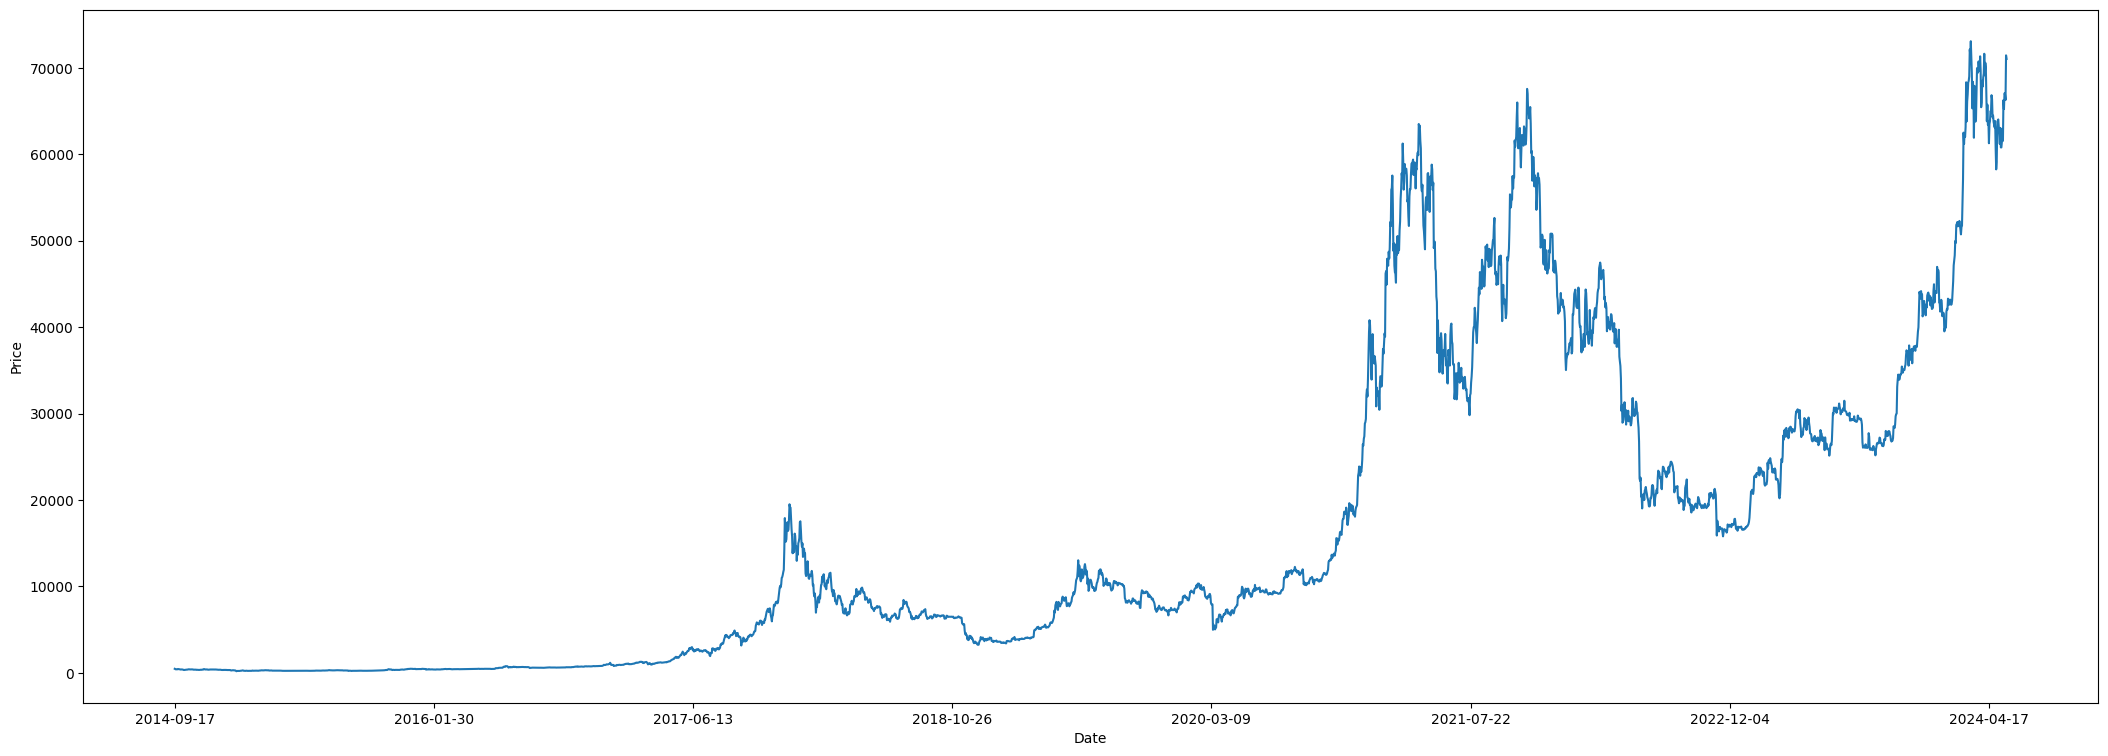

In [15]:
df.set_index('Date', inplace=True)
fig=plt.figure(figsize=(26,9))
df['Close'].plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

## Data Preprocessing

Normalise the data and create sequences of past stock prices to use as input features.

In [47]:
# Normalise the data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

time_step = 60
X, Y = [], []

# i = 3
# print(scaled_data[i : i + time_step, 0])
# print(scaled_data[i + time_step, 0])
for i in range(len(scaled_data) - time_step - 1):
    X.append(scaled_data[ i: i + time_step, 0])
    Y.append(scaled_data[i + time_step, 0])
X = np.array(X)
Y = np.array(Y)

X = X.reshape((X.shape[0], X.shape[1], 1))

## Train/Test Split

In [48]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

## Build and Train the LSTM model

In [49]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))

model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, Y_train, batch_size=64, epochs=100, validation_data=(X_test, Y_test), callbacks=[early_stop])

Epoch 1/100
44/44 [==============================] - 8s 113ms/step - loss: 0.0102 - val_loss: 8.5781e-04
Epoch 2/100
44/44 [==============================] - 2s 50ms/step - loss: 7.3313e-04 - val_loss: 7.9682e-04
Epoch 3/100
44/44 [==============================] - 2s 53ms/step - loss: 6.6427e-04 - val_loss: 9.0367e-04
Epoch 4/100
44/44 [==============================] - 2s 47ms/step - loss: 5.8396e-04 - val_loss: 0.0013
Epoch 5/100
44/44 [==============================] - 2s 47ms/step - loss: 5.8991e-04 - val_loss: 7.7344e-04
Epoch 6/100
44/44 [==============================] - 2s 50ms/step - loss: 5.2316e-04 - val_loss: 6.5245e-04
Epoch 7/100
44/44 [==============================] - 2s 49ms/step - loss: 4.9142e-04 - val_loss: 9.8221e-04
Epoch 8/100
44/44 [==============================] - 2s 52ms/step - loss: 4.6165e-04 - val_loss: 8.1522e-04
Epoch 9/100
44/44 [==============================] - 2s 56ms/step - loss: 4.5793e-04 - val_loss: 7.8095e-04
Epoch 10/100
44/44 [===============

## Make Predictions

In [50]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions to get actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train_actual = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test_actual = scaler.inverse_transform(Y_test.reshape(-1, 1))


22/22 [==============================] - 0s 13ms/step


## Visualise the Results

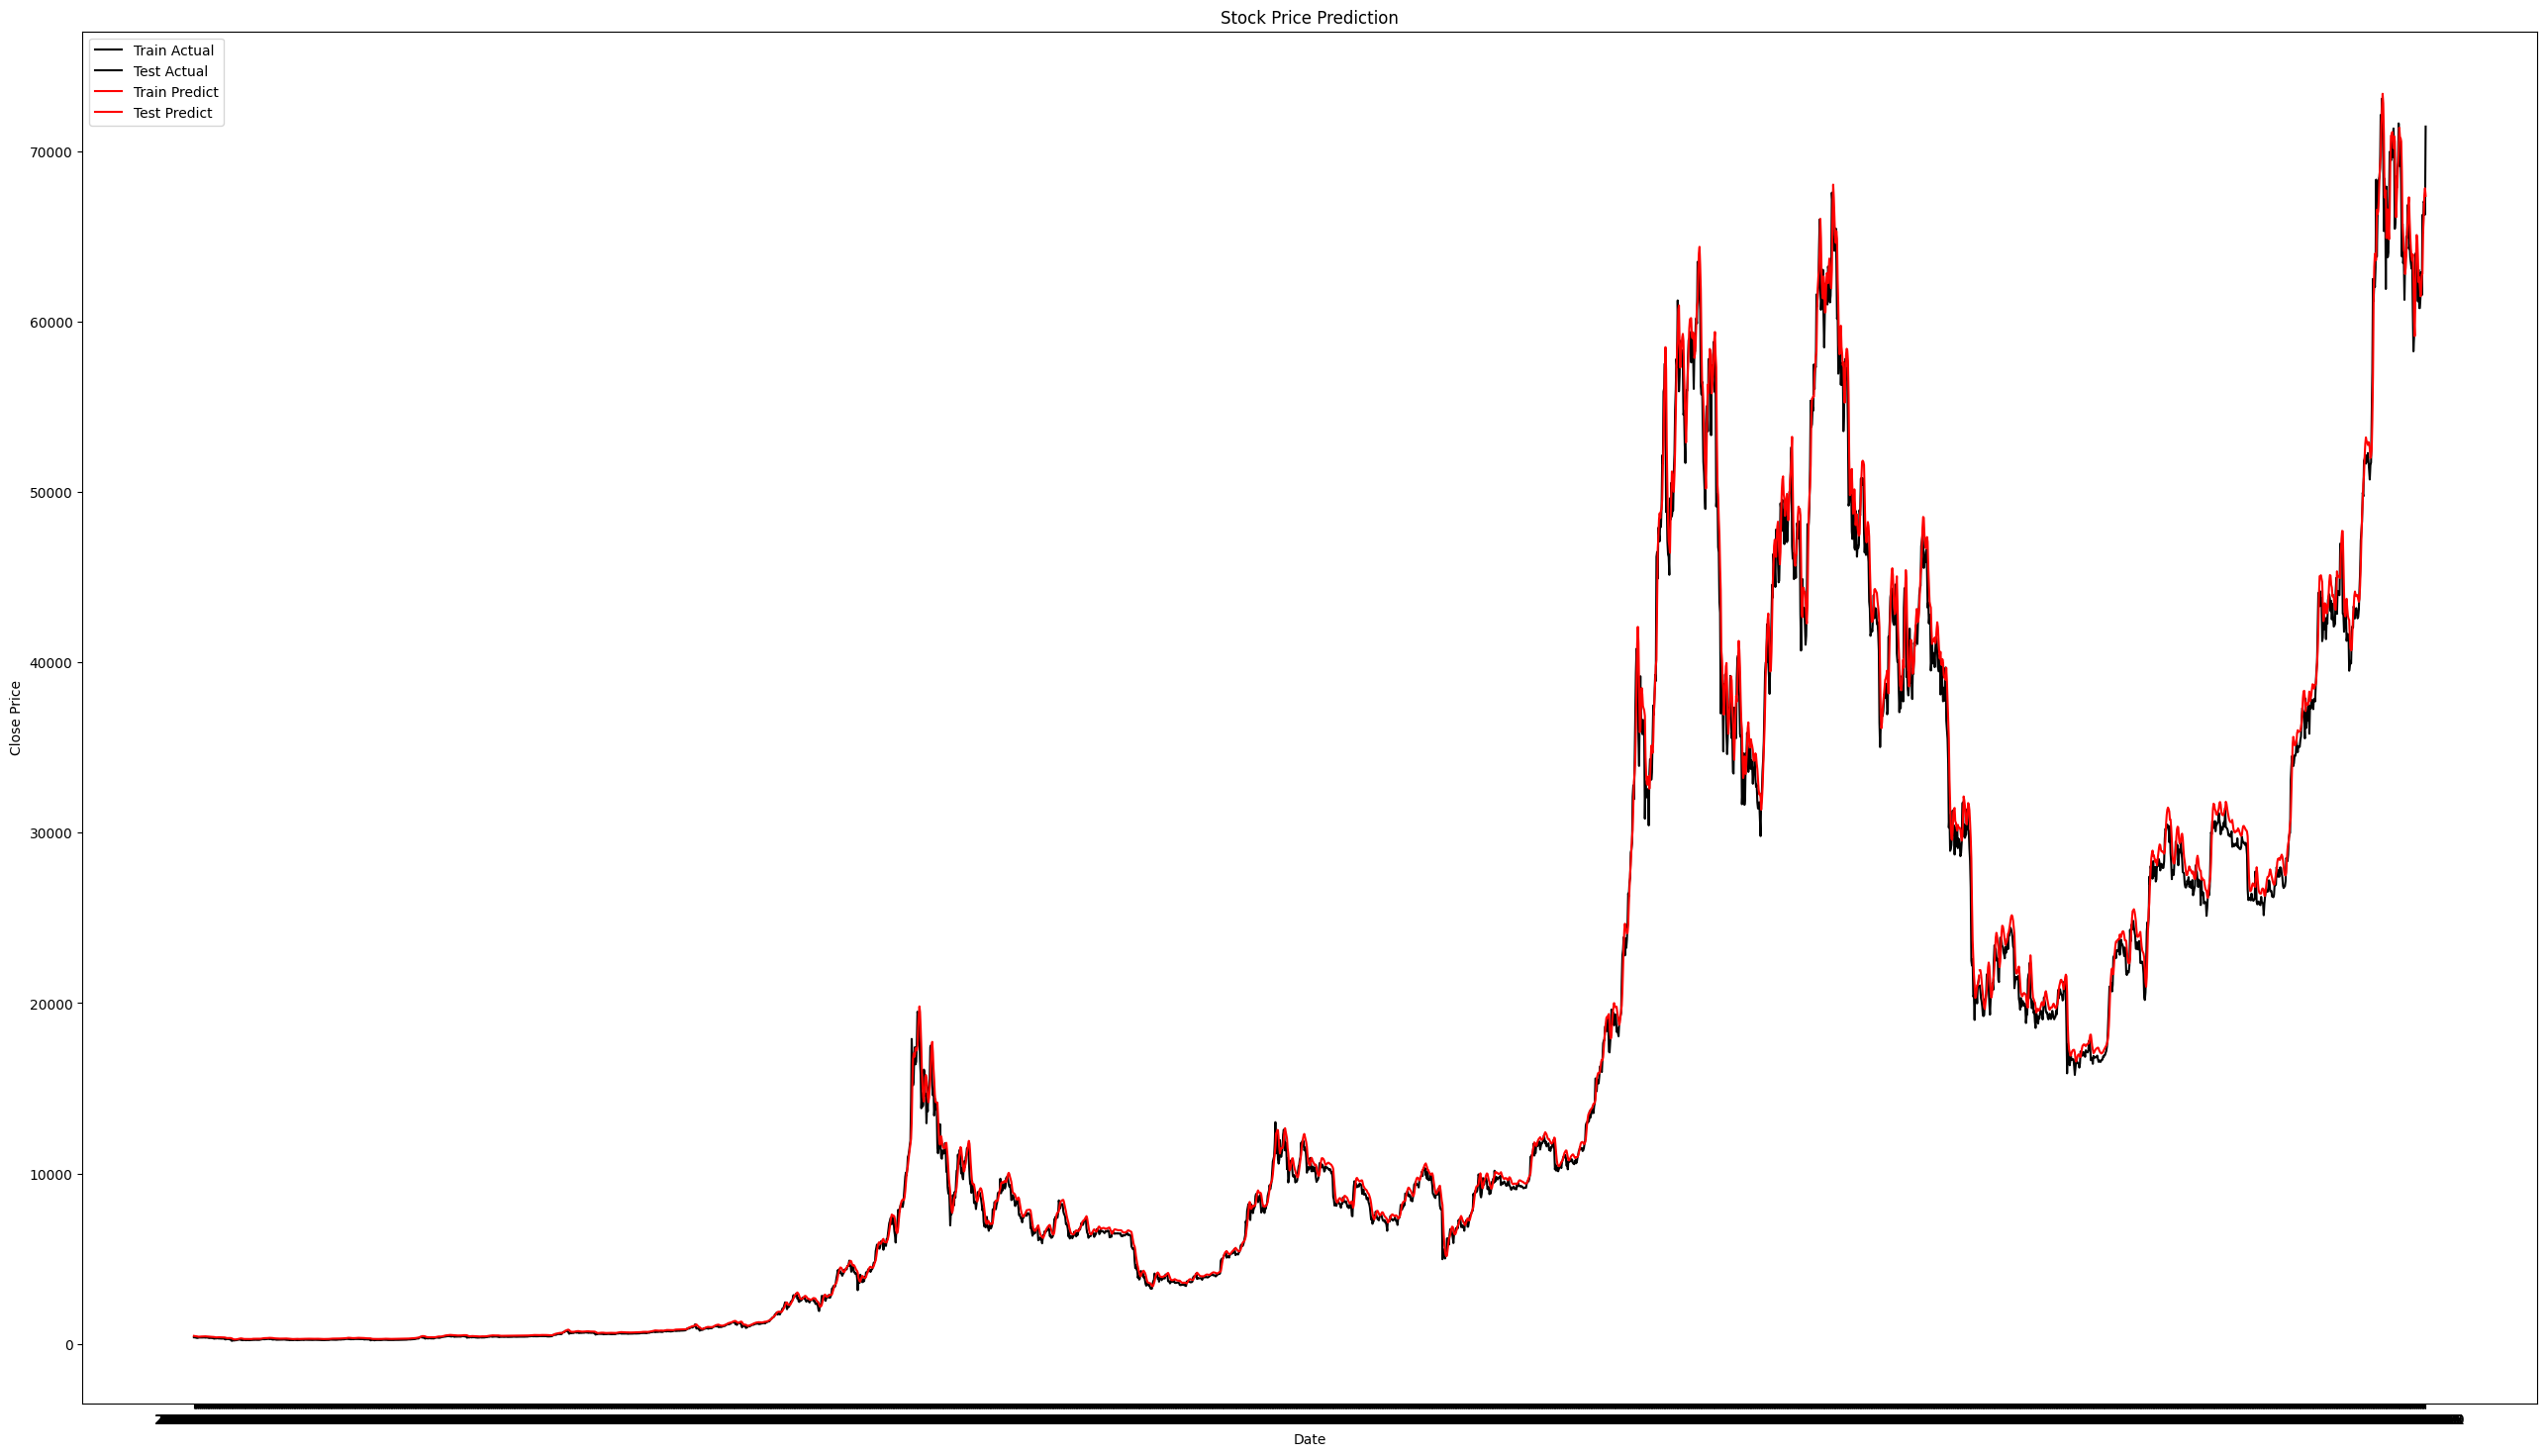

In [79]:
# Plot the results
plt.figure(figsize=(32, 18))
plt.plot(df.index[:train_size], Y_train_actual, label='Train Actual', color='black')
plt.plot(df.index[-len(Y_test_actual):], Y_test_actual, label='Test Actual', color='black')
plt.plot(df.index[:train_size], train_predict, label='Train Predict', color='red')
plt.plot(df.index[-len(test_predict):], test_predict, label='Test Predict', color='red')
plt.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


## Evaluate the Model

In [81]:
from sklearn.metrics import mean_squared_error

train_rmse = np.sqrt(mean_squared_error(Y_train_actual, train_predict))
test_rmse = np.sqrt(mean_squared_error(Y_test_actual, test_predict))

print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 1016.6710276003472
Test RMSE: 1261.0771925773738
